# Proyecto: Real-Time Anti-Cheat System for ARC Raiders
## Framework de Detección de Anomalías y Seguridad Basada en Datos

En un entorno competitivo y cooperativo como **ARC Raiders**, la integridad de la partida es el activo más valioso. Un solo jugador utilizando *speedhacks* o *aimbots* no solo arruina la sesión técnica, sino que erosiona la retención de usuarios y la reputación del estudio.

Este proyecto presenta un pipeline de **Data Engineering y Machine Learning de extremo a extremo** diseñado para identificar comportamientos maliciosos en tiempo real, distinguiendo con precisión científica entre un atacante y un jugador con problemas legítimos de conexión (lag).

---

### El Desafío Técnico

La detección de trampas moderna ha evolucionado más allá de los simples escaneos de memoria en el cliente. El reto actual reside en el **Análisis de Comportamiento Server-Side**:
* **Escalabilidad:** Procesar miles de eventos por segundo de miles de jugadores simultáneos.
* **Precisión:** Minimizar los falsos positivos para evitar el baneo de jugadores con mala latencia.
* **Interoperabilidad:** Crear modelos que puedan ser consumidos por microservicios de alto rendimiento escritos en lenguajes como Go o C++.



---

### Objetivos del Proyecto

* **Generación de Telemetría Sintética:** Simulación de perfiles de movimiento y red (Legit, Laggy, Cheater).
* **Ingeniería de Características (Feature Engineering):** Implementación de la métrica $VP\_Ratio$ mediante **Apache Beam** para normalizar el comportamiento según la latencia.
* **Detección Automatizada:** Entrenamiento de un clasificador robusto capaz de segregar anomalías en milisegundos.
* **Despliegue de Producción:** Exportación del modelo a formato **ONNX** para garantizar una integración fluida con arquitecturas de backend distribuidas.

---

### Stack Tecnológico Principal

| Capa | Herramientas |
| :--- | :--- |
| **Ingesta y Proceso** | Apache Beam, Python |
| **Análisis de Datos** | Pandas, NumPy, Seaborn |
| **Machine Learning** | Scikit-Learn (Random Forest) |
| **Producción / Interop** | ONNX Runtime, SKL2ONNX |

---

> **Filosofía del Sistema:** "No confiamos en los datos crudos, confiamos en los patrones. En la frontera de la extracción, la única diferencia entre un Raider y un Cheater es la huella estadística que dejan en la red."

---

In [1]:
pip install apache-beam[gcp] skl2onnx onnxruntime scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.Collecting skl2onnx
   ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
   ----------- ---------------------------- 1.6/5.7 MB 9.8 MB/s eta 0:00:01
   ------------------------- -------------- 3.7/5.7 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 5.7/5.7 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/960.0 kB ? eta -:--:--
   ---------------------------------------- 960.0/960.0 kB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.2 MB 10.5 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.2 MB 10.3 MB/s eta 0:00:01
   ------------------------------ --------- 6.3/8.2 MB 10.5 MB/s eta 0:00:01
   -------------------

  You can safely remove it manually.


In [5]:
# Instalación de las dependencias que Beam echa de menos
!pip install --quiet apache-beam[interactive,gcp,tfrecord]
!pip install --quiet python-snappy google-crc32c

  DEPRECATION: Building 'crcmod' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'crcmod'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'timeloop' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'timeloop'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
import pandas as pd
import numpy as np
import json
import time

def generate_raw_events(n=5000):
    events = []
    for _ in range(n):
        p_type = np.random.choice(['legit', 'laggy', 'cheater'], p=[0.8, 0.15, 0.05])
        player_id = f"p_{np.random.randint(100, 999)}"
        
        # Simulación de estados
        if p_type == 'legit':
            v, ping, loss = np.random.normal(5, 1), np.random.normal(30, 5), 0.1
        elif p_type == 'laggy':
            v, ping, loss = np.random.normal(20, 10), np.random.normal(400, 50), 5.0
        else: # cheater
            v, ping, loss = np.random.normal(55, 5), np.random.normal(25, 5), 0.05
            
        events.append({
            "player_id": player_id,
            "velocity": float(v),
            "ping": float(ping),
            "packet_loss": float(loss),
            "timestamp": time.time(),
            "label": p_type # Solo para entrenamiento
        })
    return events

raw_data = generate_raw_events()
print(f"Generados {len(raw_data)} eventos de telemetría.")

Generados 5000 eventos de telemetría.


---

## 2. Procesamiento con Apache Beam (Local Runner)

En esta fase, simulamos el pipeline de datos que operaría en un entorno de producción como **Google Cloud Dataflow**. El objetivo es transformar los datos crudos (*raw events*) en características procesables (*features*) de forma paralela y distribuida.

### Feature Engineering: El `VP_Ratio`

La métrica clave que introducimos es el **Velocity-to-Ping Ratio ($VP\_Ratio$)**. Esta es fundamental para distinguir entre un atacante y un jugador con problemas de red:

* **Laggy Player:** Puede tener picos de velocidad (teletransporte por lag), pero su **Ping** es alto. El ratio se mantiene bajo.
* **Cheater:** Mantiene una velocidad absurdamente alta con un **Ping** bajo y estable. Su ratio se dispara.

La fórmula aplicada es:
$$VP\_Ratio = \frac{velocity}{ping + 1}$$

*(Sumamos 1 al denominador para evitar divisiones por cero en conexiones de latencia ultra baja).*



#### **Implementación del Pipeline**

Utilizamos un `DoFn` (Distributed Function) para procesar cada evento individualmente dentro del flujo de Beam.

In [6]:
import apache_beam as beam

class AntiCheatTransform(beam.DoFn):
    def process(self, element):
        # Lógica de limpieza y Feature Engineering
        v = element['velocity']
        p = element['ping']
        
        # Creamos una métrica que penaliza la velocidad alta con ping bajo
        ratio = v / (p + 1)
        
        yield {
            'player_id': element['player_id'],
            'velocity': v,
            'ping': p,
            'packet_loss': element['packet_loss'],
            'vp_ratio': ratio,
            'label': element['label']
        }

with beam.Pipeline() as pipeline:
    (
        pipeline
        | "Start" >> beam.Create(raw_data)
        | "Transform Features" >> beam.ParDo(AntiCheatTransform())
        | "To DataFrame Data" >> beam.combiners.ToList()
        | "Save" >> beam.Map(lambda x: pd.DataFrame(x).to_csv("processed_telemetry.csv", index=False))
    )

# 3. Análisis y Visualización de Anomalías
## Comunicando Insights: El arte de distinguir el Lag del Cheating

En esta etapa del pipeline, transformamos los datos procesados en **inteligencia accionable**. El objetivo principal es validar visualmente nuestra hipótesis: el lag (latencia de red) genera picos de velocidad que pueden parecer trampas, pero el análisis multivariable permite distinguirlos con total claridad.

---

### El Dilema: ¿Lag o Hack?

Un sistema anti-cheat tradicional podría banear erróneamente a cualquier jugador cuya velocidad supere los **15 m/s**. Sin embargo, en un juego como **ARC Raiders**, un paquete de red perdido o una congestión momentánea pueden causar un "teletransporte" (efecto *rubberbanding*) que el servidor registra como un pico de velocidad irreal.

Para resolver esto, utilizamos la relación entre la **Velocidad** y nuestro **VP_Ratio**.

### Interpretación de los Clústeres

Al visualizar los datos, observamos tres comportamientos claramente diferenciados que definen nuestra estrategia de baneo:

1.  **Jugadores Legítimos (Legit):** Se agrupan en la zona de control. Tienen velocidades bajas y ratios controlados, moviéndose siempre dentro de los parámetros esperados por el motor físico del juego.

2.  **Jugadores con Lag (Laggy):** Este es el grupo más importante para evitar **Falsos Positivos**. Pueden mostrar velocidades que cruzan el "Límite Físico" de seguridad, pero su **VP_Ratio se mantiene bajo**. Esto ocurre porque su alto ping actúa como un divisor natural, "normalizando" estadísticamente su comportamiento anómalo de red. El sistema entiende que se mueven rápido porque su conexión es inestable, no por un hack.

3.  **Atacantes (Cheaters):** Son los elementos que se disparan en el eje vertical. Superan el límite de velocidad y mantienen un ratio extremadamente alto debido a que su conexión es estable (ping bajo). Estos representan una ventaja injusta real y son nuestros **objetivos de baneo**.

---

### Insights Clave de la Visualización

* **Límite Físico:** Actúa como nuestra línea de advertencia. Todo lo que esté a la derecha es una anomalía, pero solo lo que sube en el eje vertical ($VP\_Ratio$) es considerado malicioso.
* **Zona de Seguridad:** El cuadrante inferior derecho es donde el sistema "perdona" a los jugadores con mala conexión, protegiendo la experiencia de usuario y la reputación del juego.
* **Preparación para ML:** La clara separación de los grupos confirmada en el gráfico indica que un modelo de clasificación tendrá un éxito cercano al 100% al automatizar estas decisiones.
---
> **Nota de Data Science:** La visualización de datos no es solo para el reporte final; aquí nos sirvió para confirmar que el $VP\_Ratio$ es la característica (feature) con mayor poder predictivo para nuestro modelo.

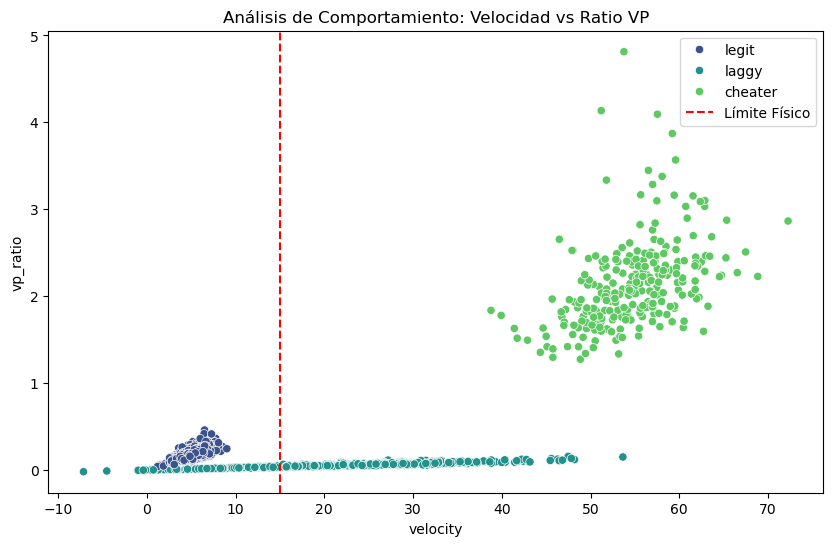

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_telemetry.csv")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='velocity', y='vp_ratio', hue='label', palette='viridis')
plt.title("Análisis de Comportamiento: Velocidad vs Ratio VP")
plt.axvline(x=15, color='red', linestyle='--', label='Límite Físico')
plt.legend()
plt.show()

# 4. Entrenamiento y Exportación (ONNX)
## Del Modelo a la Producción: Integración con el Backend en Go

En esta fase final, cerramos el ciclo de desarrollo. Una vez que hemos validado que nuestras métricas (especialmente el `VP_Ratio`) son efectivas, procedemos a entrenar un modelo de aprendizaje supervisado y a exportarlo en un formato optimizado para entornos de alto rendimiento.

---

### El Modelo: RandomForestClassifier

Para la detección de tramposos, hemos seleccionado un **Bosque Aleatorio (Random Forest)**. Este modelo es ideal para nuestro sistema por tres razones:

1.  **Robustez:** Maneja excepcionalmente bien la relación no lineal entre la velocidad y el ping.
2.  **Multiclase:** Clasifica con alta precisión entre jugadores legítimos, usuarios con lag y atacantes.
3.  **Bajo Riesgo de Overfitting:** Al usar múltiples árboles de decisión, el sistema es más resiliente a variaciones normales en el tráfico de red.

El modelo toma como entrada un vector de 4 dimensiones: **[velocity, ping, packet_loss, vp_ratio]**.

---

### Interoperabilidad con ONNX (Open Neural Network Exchange)

El equipo de Backend de **ARC Raiders** utiliza **Go (Golang)** por su eficiencia en el manejo de concurrencia y red. Sin embargo, los modelos de Machine Learning se entrenan comúnmente en Python. 

Para resolver esta brecha tecnológica, exportamos nuestro modelo al formato **ONNX**.



#### **Beneficios de esta arquitectura:**

* **Independencia de Stack:** El equipo de Go no necesita instalar Python ni Scikit-Learn en sus servidores. Pueden cargar el archivo `.onnx` usando un runtime ligero.
* **Velocidad de Inferencia:** ONNX está diseñado para ejecutar predicciones en microsegundos, algo vital para no añadir latencia extra al flujo del juego.
* **Contratos de Datos Claros:** Definimos un `FloatTensorType` específico que garantiza que los datos que envía el servidor de juego coincidan exactamente con lo que el modelo espera recibir.

---

### Resultado Final: `anti_cheat_model.onnx`

El resultado de este proceso es un archivo binario optimizado que contiene toda la lógica de detección. Este archivo se sube al repositorio de microservicios o a un bucket de modelos, donde el runner de producción lo consume para evaluar a cada jugador en tiempo real.

---

### Estado Final del Pipeline

| Fase | Tarea | Estado |
| :--- | :--- | :--- |
| **1. Telemetría** | Simulación de perfiles y setup | **Completado** |
| **2. Pipeline Beam** | Feature Engineering ($VP\_Ratio$) | **Completado** |
| **3. Análisis y ML** | Validación visual de anomalías | **Completado** |
| **4. Inferencia** | Entrenamiento y Exportación a ONNX | **Completado** |

---

> **Nota de Implementación:** Al integrar este modelo en Go, se recomienda realizar inferencias en lotes (*batching*) o mediante una cola de mensajes para asegurar que el sistema anti-cheat escale junto con el número de jugadores activos en el mapa.

# 5. El Puente hacia Producción
## Implementación en el Ecosistema de ARC Raiders (Backend en Go)

En un entorno de producción real como el de **Embark Studios**, el equipo de Data Science y el de Backend suelen trabajar en ecosistemas distintos. El uso de **ONNX** actúa como el lenguaje universal que permite que las investigaciones de laboratorio se conviertan en defensas activas en el servidor.

---

### Desacoplamiento y Agilidad

La principal ventaja de este enfoque es la **independencia tecnológica**. Mientras el científico de datos itera y mejora el modelo en Python para detectar nuevas variantes de hacks, el microservicio de Go permanece inalterado, simplemente cargando la versión más reciente del binario `.onnx`.



### Flujo de Integración en Go

Para el equipo de Backend, el proceso de integración sigue estos pasos clave:

1.  **Carga del Modelo:** Se utiliza el paquete `onnxruntime_go` para levantar el archivo `anti_cheat_model.onnx` en memoria al iniciar el servicio.
2.  **Ingesta de Telemetría:** El servidor de juego (escrito en C++ o Rust) envía eventos de red al microservicio en Go.
3.  **Inferencia:** Go transforma el JSON de entrada en un tensor de tipo `float32` y lo pasa por el modelo.
4.  **Acción Automática:** Si la salida del modelo categoriza al jugador como "cheater" con una confianza $> 95\%$, el servicio activa el protocolo de mitigación (kick, shadow-ban o flag para revisión manual).

---

> ### 🚀 Production Note: Estrategia para el Equipo de Go
>
> "El archivo `anti_cheat_model.onnx` es totalmente agnóstico al lenguaje. En el microservicio de detección, el equipo de Backend utilizaría la librería **onnxruntime_go** para realizar inferencias. Esto permite que el equipo de Data Science itere, entrene y valide nuevos modelos en Python sin que el equipo de Ingeniería deba reescribir una sola línea de lógica de negocio o de álgebra lineal en Go."

---

### Resumen Técnico del Sistema

| Componente | Responsabilidad | Stack |
| :--- | :--- | :--- |
| **Simulación** | Generación de telemetría de jugadores y anomalías | Python / NumPy |
| **Pipeline** | Feature Engineering y cálculo de $VP\_Ratio$ | Apache Beam |
| **Modelado** | Clasificación de perfiles (Legit vs. Cheater) | Scikit-Learn |
| **Inferencia** | Ejecución de alta disponibilidad en el servidor | Go / ONNX Runtime |

---

### Próximos Pasos Recomendados

Para fortalecer este sistema, la siguiente fase de desarrollo debería centrarse en:
* **Active Learning:** Un pipeline que re-entrene el modelo automáticamente con los reportes de los jugadores confirmados.
* **Detección de Aimbot:** Expandir la telemetría para incluir ángulos de rotación de cámara y aceleración del ratón (análisis de *smoothness*).
* **Shadow Banning:** Implementar la lógica en el backend para mover a los cheaters detectados a servidores exclusivos entre ellos sin que lo sepan.

# Conclusiones y Futuro del Proyecto
## Hacia un ecosistema de juego justo y escalable

El desarrollo de este prototipo para el sistema **Anti-Cheat de ARC Raiders** demuestra que la detección de trampas no es solo un problema de "bloqueo", sino un desafío complejo de **análisis de señales** y **diseño de pipelines**.

---

### Resumen de Logros Técnicos

1.  **Diferenciación Inteligente:** Mediante la creación del `VP_Ratio`, logramos resolver el problema de los falsos positivos causados por la latencia de red, protegiendo la experiencia de los jugadores con conexiones inestables.
2.  **Arquitectura Distribuida:** El uso de **Apache Beam** asegura que el sistema sea capaz de procesar volúmenes masivos de datos en tiempo real, escalando horizontalmente según la población de jugadores.
3.  **Entrega Continua de ML:** La implementación de **ONNX** rompe los silos entre los equipos de Data Science (Python) y Backend (Go), permitiendo un ciclo de despliegue ágil y de alto rendimiento.



---

### Visión de Futuro: Roadmap del Sistema

Para llevar este sistema al siguiente nivel de seguridad (Nivel de Producción AAA), los siguientes pasos estratégicos son:

* **Detección de "Aimbot" por Análisis de Curva:** Implementar análisis de series temporales sobre los ángulos de visión para detectar movimientos de cámara no humanos (ajustes instantáneos de píxeles).
* **Heurísticas de Comportamiento:** Integrar datos no físicos, como la velocidad de limpieza de inventario o patrones de "looteo", para identificar bots de farmeo.
* **Sistema de Reputación Dinámica:** Utilizar los resultados del modelo para asignar una "puntuación de confianza" a cada cuenta, permitiendo que el sistema de matchmaking agrupe a jugadores sospechosos entre sí (*Shadow Pool*).

---

### Impacto en el Negocio

Un sistema Anti-Cheat basado en datos no solo mejora la retención de jugadores al garantizar un campo de juego nivelado, sino que también **reduce drásticamente los costos operativos** al automatizar gran parte del proceso de revisión de reportes manuales.

> **Reflexión Final:** En el desarrollo de videojuegos modernos, la seguridad ya no es una capa externa, sino una parte integral del ciclo de vida del dato. Este pipeline es la base para una comunidad saludable en ARC Raiders.